In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
import sys
sys.path.append("../src/mashup/")
import numpy as np
import json
from utils import compute_mashup

In [3]:
input_folder = "../datasets/STRING/networks"
networks = ["coocurrence", "database", "fusion", "neighbor"]

## Load networks and process them

In [4]:
import pandas as pd

df = {}
nodes = set()
for net in networks:
    df[net] = pd.read_csv(f"{input_folder}/{net}.txt", sep = "\t", header = None)
    nodes   = nodes.union(set(df[net][0]).union(set(df[net][1])))


## Generate the adjacency matrices

In [5]:
nodemap = {node:i for i, node in enumerate(nodes)}
As = {}
n  = len(nodemap)
for net in networks:
    print(f"For network {net}")
    A = np.zeros((n, n))
    for p, q, w in df[net].values:
        p_, q_ = [nodemap[p], nodemap[q]]
        A[p_, q_] = w
        A[q_, p_] = w
    d = A @ np.ones((n, 1)).flatten()
    ids = np.argwhere(d == 0).flatten()
    A[ids, ids] = 1
    As[net]     = A

For network coocurrence
For network database
For network fusion
For network neighbor


## Generate the MASHUP embedding

In [6]:
E = compute_mashup(list(As.values()), reduced_dim = 1000)

13602


## Saving...

In [10]:
np.save("../datasets/STRING/networks/coo_fuse_data_neighbors.mashup1000.npy", np.abs(E))
with open("../datasets/STRING/networks/coo_fuse_data_neighbors.mashup1000.json", "w") as oj:
    json.dump(nodemap, oj)

## Loading Again...

In [2]:
E = np.load("../datasets/STRING/networks/coo_fuse_data_neighbors.mashup1000.npy")
with open("../datasets/STRING/networks/coo_fuse_data_neighbors.mashup1000.json", "r") as oj:
    emap = json.load(oj)

## Classification

In [3]:
import sys
sys.path.append("../src/scoring/")
import scoring
import predict 
import numpy as np
import json

In [4]:
import re
import graph_io
import pandas as pd

def create_predictor(E, params = {}, confidence = True):
    def predictor(training_labels):
        tlabels_f = lambda i: (training_labels[i] if i in training_labels else [])
        labels_dict = {}
        for i in range(E.shape[0]):
            l = tlabels_f(i)
            if len(l) != 0:
                labels_dict[i] = l
        return predict.perform_binary_OVA(E, labels_dict, params = params, clf_type = "LR", confidence = confidence)
    return predictor


def HGNC_STRING(locname):
    """
    STRING to protein name converter
    """
    df = pd.read_csv(locname, sep = "\t")
    string_name = df["#string_protein_id"]
    hgnc_name   = df["preferred_name"]
    return {key:value for key, value in zip(hgnc_name, string_name)}
    

def entrez_dict(IS_SYMBOL = True):
    if not IS_SYMBOL:
        ensp_dict = {}
        header    = True
        with open("/cluster/tufts/cowenlab/Projects/Multiple_Graphs/dataset/9606.protein.info.v11.5.txt", "r") as of:
            for line in of:
                if header:
                    header = False
                    continue
                words = re.split("\t", line.strip())
                if len(words) >= 2 and not words[1].startswith("ENSG"):
                    ensp_dict[words[1]] = words[0]
            
    s_e_dict = {}
    with open("/cluster/tufts/cowenlab/Projects/Denoising_Experiments/shared_data/dream_files/idmap.csv", "r") as of:
        header = True
        for line in of:
            if header:
                header = False
                continue
            words = re.split("\t", line.strip())
            if len(words) >= 2 and words[1] != "":
                if not IS_SYMBOL and words[0] in ensp_dict:
                    s_e_dict[ensp_dict[words[0]]] = int(words[1])
                else:
                    s_e_dict[words[0]] = int(words[1])
    rev_dict = {s_e_dict[k]: k for k in s_e_dict}
    return s_e_dict, rev_dict

def get_labels(go_type, min_level, min_prot, node_list, is_STRING = False):
    filter_protein = {"namespace": go_type, "lower_bound": min_prot}
    filter_labels  = {"namespace": go_type, "min_level": min_level}
    filter_parents = {"namespace": go_type}
    # Using entrez dict to do symbol->entrez mapping
    s_entrez, entrez_s = entrez_dict()

    if is_STRING:
        hgnc_string_map = HGNC_STRING("/cluster/tufts/cowenlab/Projects/Denoising_Experiments/9606.protein.info.v11.5.txt")
        s_entrez = {hgnc_string_map[key]: value for key, value in s_entrez.items() if key in hgnc_string_map}
        entrez_s = {value:key for key, value in s_entrez.items()}
    e_symbols          = [s_entrez[k] for k in node_list if k in s_entrez]

    f_labels, labels_dict, parent_dict = graph_io.get_go_labels_and_parents("../datasets/GO/go-basic.obo",
                                                                            "../datasets/GO/gene2go",
                                                                            filter_protein, 
                                                                            filter_labels,
                                                                            filter_parents,
                                                                            e_symbols,
                                                                            anno_map = lambda x: entrez_s[x])
    proteins_to_go     = {}
    for l in labels_dict:
        prots = labels_dict[l]
        for p in prots:
            if p not in proteins_to_go:
                proteins_to_go[p] = []
            proteins_to_go[p] += [l]
    labels = {i: proteins_to_go[node_list[i]] 
              for i in range(len(node_list)) if node_list[i] in proteins_to_go}
    return labels

In [5]:
# Computing the GO labels
labels = {}
gos = ["molecular_function", "cellular_component", "biological_process"]
for GO_TYPE in gos:
    labels[GO_TYPE] = get_labels(GO_TYPE, 5, 50, list(emap.keys()), True)

HMS:0:00:04.167964 335,350 annotations, 20,702 genes, 18,726 GOs, 1 taxids READ: ../datasets/GO/gene2go 
18674 IDs in loaded association branch, molecular_function
  EXISTS: ../datasets/GO/go-basic.obo
../datasets/GO/go-basic.obo: fmt(1.2) rel(2021-12-15) 47,157 GO Terms; optional_attrs(relationship)
Read gene2go.dat File
Number of Labels: 40
HMS:0:00:04.350525 335,350 annotations, 20,702 genes, 18,726 GOs, 1 taxids READ: ../datasets/GO/gene2go 
18674 IDs in loaded association branch, cellular_component
  EXISTS: ../datasets/GO/go-basic.obo
../datasets/GO/go-basic.obo: fmt(1.2) rel(2021-12-15) 47,157 GO Terms; optional_attrs(relationship)
Read gene2go.dat File
Number of Labels: 85
HMS:0:00:04.457037 335,350 annotations, 20,702 genes, 18,726 GOs, 1 taxids READ: ../datasets/GO/gene2go 
18674 IDs in loaded association branch, biological_process
  EXISTS: ../datasets/GO/go-basic.obo
../datasets/GO/go-basic.obo: fmt(1.2) rel(2021-12-15) 47,157 GO Terms; optional_attrs(relationship)
Read gen

In [6]:
results = []
for go in gos:
    kfold = 5
    f1 = scoring.kfoldcv_with_pr(kfold, 
                            labels[go], 
                            create_predictor(E))
    acc = scoring.kfoldcv(kfold,
                    labels[go],
                    create_predictor(E, confidence = False)) 
    results.append((go, f1, acc))

The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 40


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 85


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here
The number of All the Labels 207


/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/cluster/tufts/cowenlab/.envs/denoise/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org

Here


In [7]:
results

[('molecular_function',
  [0.4907112323093687,
   0.4739209943656252,
   0.49432260672629086,
   0.47565540247251004,
   0.4942102326648412],
  [0.503690036900369,
   0.49907749077490776,
   0.5350553505535055,
   0.5156826568265682,
   0.5174632352941176]),
 ('cellular_component',
  [0.407721895989642,
   0.37768474744227093,
   0.3902120440657082,
   0.4040865656117485,
   0.41165012794160466],
  [0.4340567612687813,
   0.44351697273233165,
   0.44908180300500833,
   0.46466332776850305,
   0.46055555555555555]),
 ('biological_process',
  [0.35229542980076,
   0.3430747718212928,
   0.3508635782618327,
   0.36127593149826437,
   0.33684692979322983],
  [0.41791942273000604,
   0.40348767288033677,
   0.40709561034275404,
   0.4239326518340349,
   0.4331133773245351])]

## Plot the results

In [5]:
import numpy as np
import pandas as pd

results_mashup = [('molecular_function',
  [0.4907112323093687,
   0.4739209943656252,
   0.49432260672629086,
   0.47565540247251004,
   0.4942102326648412],
  [0.503690036900369,
   0.49907749077490776,
   0.5350553505535055,
   0.5156826568265682,
   0.5174632352941176]),
 ('cellular_component',
  [0.407721895989642,
   0.37768474744227093,
   0.3902120440657082,
   0.4040865656117485,
   0.41165012794160466],
  [0.4340567612687813,
   0.44351697273233165,
   0.44908180300500833,
   0.46466332776850305,
   0.46055555555555555]),
 ('biological_process',
  [0.35229542980076,
   0.3430747718212928,
   0.3508635782618327,
   0.36127593149826437,
   0.33684692979322983],
  [0.41791942273000604,
   0.40348767288033677,
   0.40709561034275404,
   0.4239326518340349,
   0.4331133773245351])]

rmashup = [("mashup", t, np.mean(x), np.mean(y)) for t, x, y in results_mashup]

results_glide = [('molecular_function',
  [0.5971742735941947,
   0.5968815563292742,
   0.5700622610150747,
   0.5919819866669759,
   0.5903995856925937],
  [0.5498154981549815,
   0.6005535055350554,
   0.5784132841328413,
   0.6033210332103321,
   0.5854779411764706]),
 ('cellular_component',
  [0.5482389428955244,
   0.5448515450266416,
   0.5527816406506847,
   0.5608234837731302,
   0.5535590414115613],
  [0.6093489148580968,
   0.6026711185308848,
   0.6054535336672231,
   0.5915414579855315,
   0.6238888888888889]),
 ('biological_process',
  [0.44615718123694054,
   0.42890897499174613,
   0.4337744686280131,
   0.4311428682938999,
   0.4252612557830509],
  [0.47805171377029465,
   0.48947684906794947,
   0.48947684906794947,
   0.4930847865303668,
   0.46490701859628075])]

rglide = [("glide", t, np.mean(x), np.mean(y)) for t, x, y in results_glide]

In [17]:
import seaborn as sns
df = pd.DataFrame(rmashup + rglide, columns=["Method", "GO", "F1", "Accuracy"])
df1 = df[["Method", "GO", "F1"]]
df2 = df[["Method", "GO", "Accuracy"]]
df1.columns = ["Method", "GO", "Scores"]
df2.columns = ["Method", "GO", "Scores"]
df1["Metric"] = "F1"
df2["Metric"] = "Accuracy"
df3 = pd.concat([df1, df2])
df3

,Method,GO,Scores,Metric
0,mashup,molecular_function,0.485764,F1
1,mashup,cellular_component,0.398271,F1
2,mashup,biological_process,0.348871,F1
3,glide,molecular_function,0.589300,F1
4,glide,cellular_component,0.552051,F1
5,glide,biological_process,0.433049,F1
0,mashup,molecular_function,0.514194,Accuracy
1,mashup,cellular_component,0.450375,Accuracy
2,mashup,biological_process,0.417110,Accuracy
3,glide,molecular_function,0.583516,Accuracy


[Text(0.5, 1.0, 'F1')]

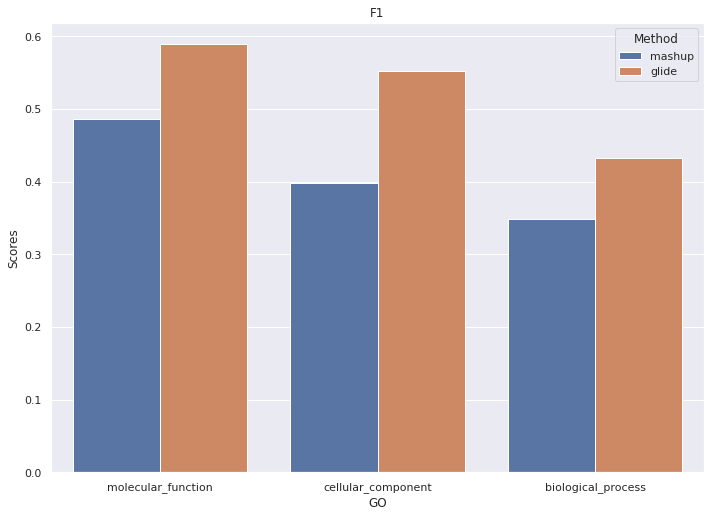

In [32]:
## F1 SCORE
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(data = df3[df3["Metric"] == "F1"], x = "GO", y= "Scores", hue = "Method").set(title = "F1")

[Text(0.5, 1.0, 'Accuracy')]

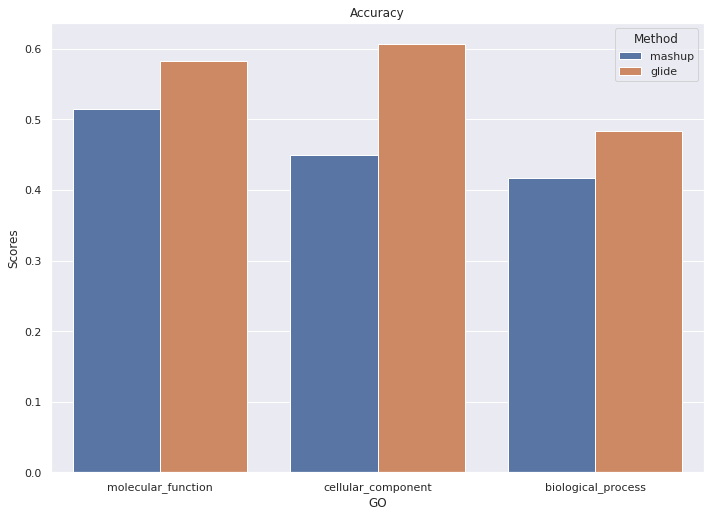

In [33]:
# Accuracy

sns.barplot(data = df3[df3["Metric"] == "Accuracy"], x = "GO", y= "Scores", hue = "Method").set(title = "Accuracy")